# Hidden Markov Models for Identifying Market Regimes

Hidden Markov Models (HMMs) are well-suited for market regime detection because they can effectively model and identify unobservable market conditions that influence observable data, such as stock prices or returns. Here’s why HMMs are useful for this task:

1.  Unobservable Regimes: HMMs can uncover hidden states (market regimes) that are not directly observable but significantly impact market behavior. These states could represent different market conditions like bull markets, bear markets, or high and low volatility periods.

2.  Dynamic Transitions: HMMs model the probabilities of transitioning between different regimes, allowing them to capture shifts in market conditions over time. This helps in understanding how and when market states change.

3.  Probabilistic Framework: By using emission probabilities, HMMs can estimate the likelihood of observing certain market data (e.g., returns) given each regime. This probabilistic approach helps in identifying the most likely market regime at any given time.

4.  Data Adaptability: HMMs can adapt to changes in market dynamics by updating the model parameters based on new data, making them a flexible tool for analyzing evolving market conditions.

Overall, HMMs provide a structured way to identify and analyze hidden market regimes, offering valuable insights into market behavior and helping in the development of strategies tailored to different market conditions.

### Imports

In [1]:
# import packages

# Data Management
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

# HMM
from hmmlearn.hmm import GaussianHMM

# Reporting
import matplotlib.pyplot as plt

# Remove unwanted warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\andre\anaconda3\envs\env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Data Management

In [2]:
# Data Extraction
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3650)

symbol = "SPY"
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


### Feature Engineering

In [3]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Returns,Range
Date,,,,,,,,
2014-08-08,191.460007,193.369995,190.949997,193.240005,161.744522,117014000,0.011569,0.012673
2014-08-11,193.970001,194.660004,193.710007,193.800003,162.213257,74544000,0.002898,0.004904
2014-08-12,193.610001,194.149994,192.940002,193.529999,161.987259,73632000,-0.001393,0.006271
2014-08-13,194.289993,195.059998,193.960007,194.839996,163.083771,69047000,0.006769,0.005671
2014-08-14,195.160004,195.759995,194.979996,195.759995,163.853821,57371000,0.004722,0.004000


In [4]:
# Time Intervals
t_steps = [1, 2]
t_features = ['Returns', 'Range']
for ts in t_steps:
    for tf in t_features:
        df[f'{tf}_T{ts}'] = df[tf].shift(ts)

In [5]:
df.dropna(inplace=True)
print(df.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-29  546.020020  547.049988  542.719971  544.760010  544.760010   
2024-07-30  546.260010  547.340027  538.520020  542.000000  542.000000   
2024-07-31  548.979980  553.500000  547.580017  550.809998  550.809998   
2024-08-01  552.570007  554.869995  539.429993  543.010010  543.010010   
2024-08-02  535.750000  536.989990  528.599976  532.900024  532.900024   

              Volume   Returns     Range  Returns_T1  Range_T1  Returns_T2  \
Date                                                                         
2024-07-29  39515800  0.000588  0.007978    0.011200  0.010527   -0.005210   
2024-07-30  46853600 -0.005066  0.016378    0.000588  0.007978    0.011200   
2024-07-31  65663400  0.016255  0.010811   -0.005066  0.016378    0.000588   
2024-08-01  76428700 -0.014161  0.028623    0.016255  0.010811   -0.005066   
2024-08-02  8

In [6]:
# Structure Data
X_train = df[["Returns", "Range", "Returns_T1", "Range_T1"]]
X_train.head()

,Returns,Range,Returns_T1,Range_T1
Date,,,,
2014-08-12,-0.001393,0.006271,0.002898,0.004904
2014-08-13,0.006769,0.005671,-0.001393,0.006271
2014-08-14,0.004722,0.004000,0.006769,0.005671
2014-08-15,-0.000205,0.012043,0.004722,0.004000
2014-08-18,0.008379,0.003864,-0.000205,0.012043


### HMM Model

In [7]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type="full", n_iter=1000, random_state=0).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 37317.87105936386


In [8]:
hidden_states = hmm_model.predict(X_train)
print(hidden_states[:10])

[0 0 0 0 0 0 0 0 0 0]


In [9]:
# Regime state means for each feature
print("Regime state means:", hmm_model.means_)

Regime state means: [[ 0.00194017  0.00664579  0.00222869  0.00683315]
 [-0.00449881  0.01694021  0.00176663  0.01036692]
 [ 0.00270289  0.01204782 -0.00223158  0.01664166]
 [-0.00495611  0.03149525 -0.00639946  0.0311806 ]]


In [10]:
# Regime state covars for each feature
print("Regime state covars:", hmm_model.covars_)

Regime state covars: [[[ 3.06107465e-05  1.11141626e-05  7.00808258e-06  9.82730909e-06]
  [ 1.11141626e-05  1.42809565e-05  7.16311080e-06  9.85105761e-06]
  [ 7.00808258e-06  7.16311080e-06  3.17461384e-05  1.19884696e-05]
  [ 9.82730909e-06  9.85105761e-06  1.19884696e-05  1.50298684e-05]]

 [[ 1.73314195e-04  2.31732671e-05  2.39562274e-05  3.22108280e-05]
  [ 2.31732671e-05  5.47775455e-05  2.47020969e-05  3.60428952e-05]
  [ 2.39562274e-05  2.47020969e-05  8.84490879e-05  3.09366489e-05]
  [ 3.22108280e-05  3.60428952e-05  3.09366489e-05  4.14671298e-05]]

 [[ 1.02326238e-04  2.46742157e-05  1.66278839e-05  2.66198340e-05]
  [ 2.46742157e-05  3.79685256e-05  1.12609622e-05  3.01864289e-05]
  [ 1.66278839e-05  1.12609622e-05  1.78883805e-04  2.17341469e-05]
  [ 2.66198340e-05  3.01864289e-05  2.17341469e-05  4.73128488e-05]]

 [[ 8.37140860e-04  3.43683323e-05 -1.58179815e-04  1.15611048e-04]
  [ 3.43683323e-05  2.90486817e-04  2.65506716e-05  1.58328186e-04]
  [-1.58179815e-04  2

### Data Visualization

In [11]:
# Structure the prices for plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df["Adj Close"].values.astype(float)
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

Correct number of rows:  True


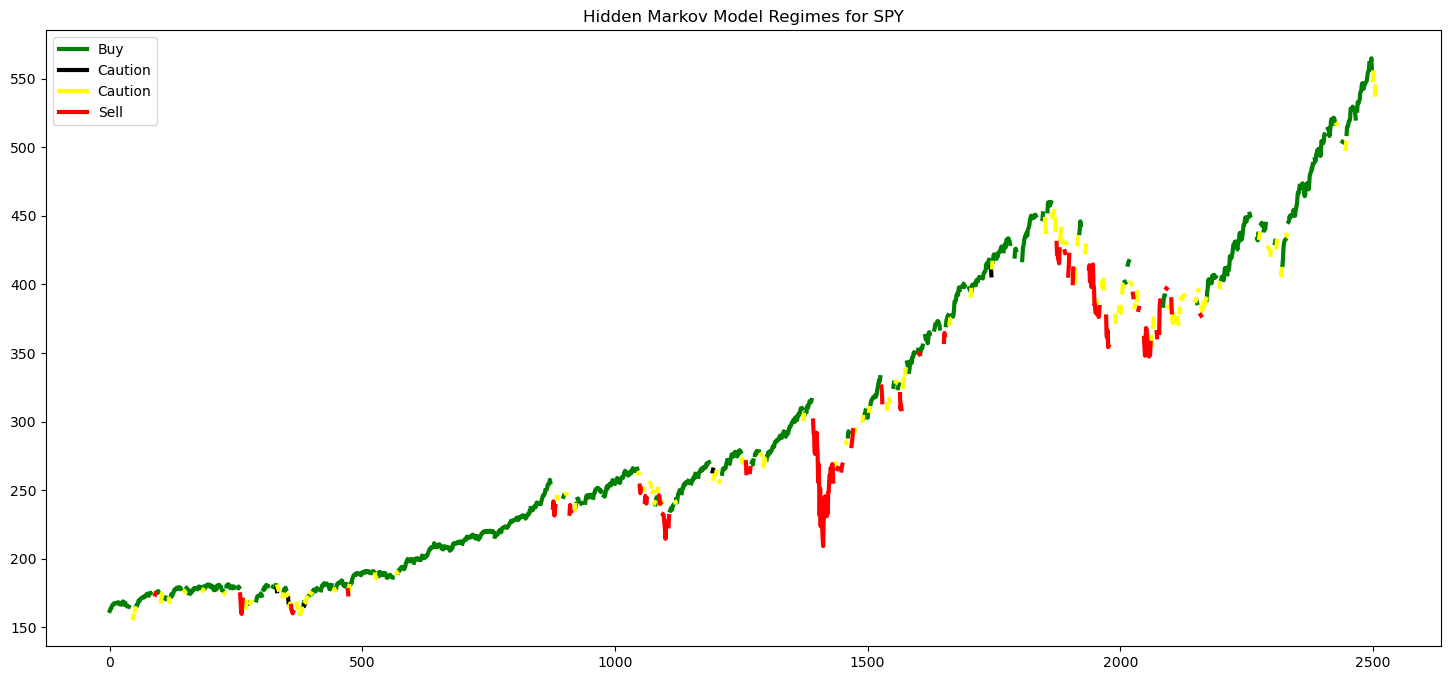

In [16]:
# Plot Chart
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, color="green", linewidth=3, label="Buy")
plt.plot(labels_1, color="black", linewidth=3, label="Caution")
plt.plot(labels_2, color="yellow", linewidth=3, label="Caution")
plt.plot(labels_3, color="red", linewidth=3, label="Sell")

# Add title using f-string
plt.title(f"Hidden Markov Model Regimes for {symbol}")

# Optionally, add a legend to identify each line
plt.legend()
plt.show()

Regime Shifts:

The HMM captures multiple regime shifts over time. The transitions between green, yellow, and red indicate changes in the underlying market conditions.
The model appears to identify periods of market stress (e.g., during market downturns) by switching to a red "Sell" regime. These periods are often followed by cautionary yellow phases before returning to a green "Buy" regime.

Trend Detection:

The HMM seems to effectively capture the overall bullish trend in the SPY, as indicated by the predominance of green "Buy" signals during uptrends.
However, there are frequent yellow and red regime shifts, which might reflect short-term market fluctuations or noise rather than significant regime changes.

Overfitting/Noise Sensitivity:

There appears to be some degree of sensitivity to market noise, as indicated by the relatively frequent shifts between yellow, red, and green regimes. This might suggest that the HMM is reacting to short-term market volatility rather than genuine regime changes.

Suggestions for Improving HMM to Better Detect Market Regimes:
Increase the Number of States:

Currently, the HMM uses four states (Buy, Caution, Sell). Increasing the number of states could allow the model to better distinguish between different types of market environments (e.g., high volatility uptrends, low volatility downtrends).

Feature Engineering:

Incorporate additional features that capture broader market conditions (e.g., volatility measures like the VIX, interest rates, or macroeconomic indicators) to improve the model's ability to distinguish between regimes.
Use technical indicators such as moving averages, RSI, or MACD as inputs to help the HMM better capture market momentum or reversal signals.

Adjust the Observation Model:

Experiment with different types of observation distributions within the HMM. For instance, using a Gaussian mixture model (GMM) or a t-distribution could help the model better capture fat tails and skewness in market returns.

Smoothing Techniques:

Apply smoothing techniques to the HMM predictions to reduce the sensitivity to short-term noise. For instance, using a longer look-back period for the HMM or applying a moving average to the predicted states could help stabilize the regime detection.

Regime Duration Modeling:

Introduce a duration modeling component where the HMM takes into account the typical duration of a regime. This can prevent the model from switching states too quickly based on short-term fluctuations.

Regularization:

Regularize the model to prevent overfitting to short-term noise. Techniques such as Bayesian HMMs or adding a penalty for rapid regime switching might help stabilize the regime predictions.

Out-of-Sample Validation:

Conduct out-of-sample validation to ensure that the HMM generalizes well to new data. If the model frequently overfits to the in-sample data, it might not perform well in real-time predictions.